# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
#import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rabelani\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rabelani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing data

In [2]:
#import the train data
train_df = pd.read_csv('train.csv')
train_df.columns = [col.replace(' ', '_') for col in train_df.columns]
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [3]:
#import the test data
test_df = pd.read_csv('test.csv')
test_df.columns = [col.replace(' ', '_') for col in test_df.columns]
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


#Data cleaning

### Text cleaning

In [4]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [5]:
cleaned_train_df = train_df.copy()
cleaned_train_df['message'] = train_df['message'].apply(lambda x:clean_text(x))
cleaned_train_df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt rawstory researchers say we have three year...,698562
3,1,todayinmaker wired was a pivotal year in the...,573736
4,1,rt soynoviodetodas its and a racist sexist cl...,466954


## Tokenization

In [ ]:
tokeniser = TreebankWordTokenizer()

In [ ]:
cleaned_train_df['tokens'] = cleaned_train_df['message'].apply(tokeniser.tokenize)

In [ ]:
cleaned_train_df.head()

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr..."
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, was, a, pivotal, year, i..."
4,1,rt soynoviodetodas its and a racist sexist cl...,466954,"[rt, soynoviodetodas, its, and, a, racist, sex..."


## Stop words

In [ ]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

In [ ]:
cleaned_train_df['tokens'] = cleaned_train_df['tokens'].apply(remove_stop_words)

In [ ]:
cleaned_train_df.head()

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[like, lack, evidence, anthropogenic, global, ..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, three, years,..."
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, pivotal, year, war, clim..."
4,1,rt soynoviodetodas its and a racist sexist cl...,466954,"[rt, soynoviodetodas, racist, sexist, climate,..."


## Stemming 

In [ ]:
def stemmer(words, stemmer):
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(word) for word in words]

In [ ]:
cleaned_train_df['stem'] = cleaned_train_df['tokens'].apply(stemmer, args=(stemmer, ))

## Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(words, lemmatizer):
    #lemmatizer = WordNetLemmatizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]    

In [ ]:
cleaned_train_df['lemma'] = cleaned_train_df['tokens'].apply(lemma, args=(lemmatizer, ))

In [ ]:
cleaned_train_df.drop('message2', axis =1,inplace = True) 

In [ ]:
cleaned_train_df.head()

,sentiment,message,tweetid,tokens,stem,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, ..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, three, years,...","[rt, rawstori, research, say, three, year, act...","[rt, rawstory, researcher, say, three, year, a..."
3,1,todayinmaker wired was a pivotal year in the...,573736,"[todayinmaker, wired, pivotal, year, war, clim...","[todayinmak, wire, pivot, year, war, climat, c...","[todayinmaker, wired, pivotal, year, war, clim..."
4,1,rt soynoviodetodas its and a racist sexist cl...,466954,"[rt, soynoviodetodas, racist, sexist, climate,...","[rt, soynoviodetoda, racist, sexist, climat, c...","[rt, soynoviodetodas, racist, sexist, climate,..."


# Text feature extraction

In [7]:
y = cleaned_train_df['sentiment']
X = cleaned_train_df['message']

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

In [9]:
X_vectorized.shape

(15819, 21920)

In [10]:
X = X_vectorized.toarray()

# Ballanced class

In [24]:
type_labels =[-1,0,1,2]

In [25]:
data = np.concatenate([X, y[:,np.newaxis]], axis=1)

MemoryError: 

In [12]:
data

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
temp = cleaned_train_df.groupby('sentiment').count()['message'].reset_index().sort_values(by='message',ascending=False)

In [14]:
temp_df = temp.set_index('sentiment')

In [15]:
temp_df

,message
sentiment,
1,8530
2,3640
0,2353
-1,1296


In [16]:
# Let's pick a class size of roughly half the size of the largest size
class_size = 4265

In [17]:
resampled_classes = []

# For each label
for i in type_labels:
    # Get num. of observations from this class
    label_size = temp_df.loc[i]['message']
    
    # If label_size < class size the upsample, else downsample
    if label_size < class_size:
        # Upsample
        label_data = data[data[:,-1] == i]
        label_resampled = resample(label_data,
                                  replace=True, # sample with replacement (we need to duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
    else:
        # Downsample
        label_data = data[data[:,-1] == i]
        label_resampled = resample(label_data,
                                  replace=False, # sample without replacement (no need for duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
        
    resampled_classes.append(label_resampled)

MemoryError: 

In [18]:
resampled_data = np.concatenate(resampled_classes, axis=0)

ValueError: need at least one array to concatenate

In [19]:
X_resampled = resampled_data[:,:-1]

In [20]:
y_resampled = resampled_data[:,-1]

In [21]:
(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  -1 1296]
 [   0 2353]
 [   1 8530]
 [   2 3640]]


In [22]:
(unique, counts) = np.unique(y_resampled, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[-1.000e+00  4.265e+03]
 [ 0.000e+00  4.265e+03]
 [ 1.000e+00  4.265e+03]
 [ 2.000e+00  4.265e+03]]


In [33]:
# Separate minority and majority classes
neg_one = train_df[train_df['sentiment']==-1]
zero = train_df[train_df['sentiment']==0]
one = train_df[train_df['sentiment']==1]
two= train_df[train_df['sentiment']==2]

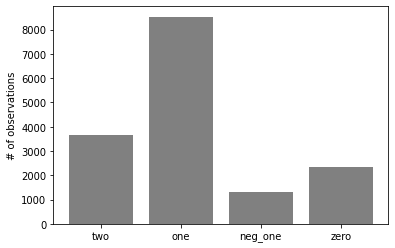

In [34]:
# Get all possible labels

labels = train_df['sentiment'].unique()
heights = [len(neg_one),len(zero),len(one),len(two)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['neg_one','zero','one','two'])
plt.ylabel("# of observations")
plt.show()

In [ ]:
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

# Splitting the train data into training and validation set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=27)

# Training and evaluating the model

In [ ]:
#Support vector classifier

In [ ]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

C:\Users\Rabelani\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
f1_score(y_test, y_pred, average="macro")

In [ ]:
#support vector classifier grid search

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':(0.25,1.0),
              'gamma': (1,2)}

In [ ]:
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)

In [ ]:
y_pred_opt = clf.predict(X_test)

In [ ]:
f1_score(y_test, y_pred_opt, average="macro")

In [ ]:
#Kneighbors classifier

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred= knn.predict(X_test)

In [13]:
f1_score(y_test, knn_pred, average='micro')

0.5632111251580278

In [ ]:
#Kneighbors classifier grid search 

In [17]:
from sklearn.model_selection import GridSearchCV

In [20]:
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
score = 'f1_micro'
param_grid = {'n_neighbors': ks}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, scoring=score)

In [ ]:
grid_knn.fit(X_train, y_train)
grid_knn.best_params_

C:\Users\Rabelani\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#Random forest

In [37]:
names = ['Logistic Regression','Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

classifiers = [ 
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [ ]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred,average='micro')
    recall    = metrics.recall_score(y_train, y_pred,average='micro')
    
    f1        = metrics.f1_score(y_train, y_pred,y_pred,average='micro')    
    f1_test   = metrics.f1_score(y_test, y_pred_test,y_pred,average='micro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, precision, recall,accuracy, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)
results.sort_values('F1 Train', ascending=False)

Fitting Logistic Regression model...


C:\Users\Rabelani\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rabelani\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Rabelani\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Rabelani\Anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Rabelani\Anaconda3\en

... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...


# Feature extraction from test data

In [ ]:
#cleaning text data
cleaned_test_df = test_df.copy()
cleaned_test_df['message'] = test_df['message'].apply(lambda x:clean_text(x))
cleaned_test_df.head()

In [ ]:
test_x = cleaned_test_df['message']
test_vect = vectorizer.transform(test_x)

# Making predictions on test data

In [ ]:
y_pred = rfc.predict(test_vect)

In [ ]:
test['sentiment'] = y_pred

# Creating output csv for submission

In [ ]:
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)